In [1]:
import pickle
import numpy as np
import cv2
import warnings

warnings.filterwarnings('ignore')

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-05-15 08:38:16--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-05-15 08:38:16--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  27.5MB/s    in 9.8s    

2025-05-15 08:38:26 (24.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
import os
import pandas as pd
import shutil
import tensorflow as tf

# Parameters
BATCH_SIZE = 64
IMG_SIZE = (64, 64)
NUM_CLASSES = 200  # Tiny ImageNet has 200 classes
MEAN = tf.constant([0.4802, 0.4481, 0.3975])
STD = tf.constant([0.2770, 0.2691, 0.2821])

# Paths
val_dir = '/kaggle/working/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_ann_file = os.path.join(val_dir, 'val_annotations.txt')

# 🔁 Step 1: Reorganize validation images into class folders
val_df = pd.read_csv(val_ann_file, sep='\t', header=None)
val_df.columns = ['filename', 'class', 'x1', 'y1', 'x2', 'y2']

# Create class directories
for _, row in val_df.iterrows():
    class_dir = os.path.join(val_images_dir, row['class'])
    os.makedirs(class_dir, exist_ok=True)
    
    src = os.path.join(val_images_dir, row['filename'])
    # Keep the original extension
    dst = os.path.join(class_dir, row['filename'])
    
    if os.path.exists(src):
        shutil.copy2(src, dst)  # Using copy instead of rename to avoid issues

# Remove leftover loose images (after copying them to class folders)
for f in os.listdir(val_images_dir):
    path = os.path.join(val_images_dir, f)
    if os.path.isfile(path):
        os.remove(path)

# 🔄 Normalize function
def normalize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - MEAN) / STD
    return image, label

# 📥 Load datasets using tf.data
train_dir = '/kaggle/working/tiny-imagenet-200/train'
val_dir_reorg = val_images_dir  # Now properly reorganized

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir_reorg,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# ✅ Normalize and optimize
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2025-05-15 08:38:40.949474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747298321.170991      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747298321.243706      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747298335.220298      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747298335.221032      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [4]:
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input

def MV2Block(x, out_channels, expansion=2, stride=1):
    in_channels = x.shape[-1]
    hidden_dim = in_channels * expansion

    x1 = layers.Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('swish')(x1)

    x1 = layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('swish')(x1)

    x1 = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x1)
    x1 = layers.BatchNormalization()(x1)

    if stride == 1 and in_channels == out_channels:
        x1 = layers.Add()([x, x1])
    return x1

In [5]:
def TransformerBlock(x, embed_dim, num_heads, mlp_ratio=2):
    # LayerNorm + MHA
    res = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, res])

    # MLP
    res = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(embed_dim * mlp_ratio, activation='swish')(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Add()([x, res])
    return x

In [6]:
def MobileViTBlock(x, patch_size, embed_dim, depth, num_heads):
    local = layers.Conv2D(embed_dim, 3, padding='same')(x)
    local = layers.BatchNormalization()(local)
    local = layers.Activation('swish')(local)

    h, w = local.shape[1], local.shape[2]
    x_flat = layers.Reshape((h * w, embed_dim))(local)

    for _ in range(depth):
        x_flat = TransformerBlock(x_flat, embed_dim=embed_dim, num_heads=num_heads)

    x_trans = layers.Reshape((h, w, embed_dim))(x_flat)
    fusion = layers.Concatenate()([x_trans, local])
    fusion = layers.Conv2D(embed_dim, 3, padding='same')(fusion)
    fusion = layers.BatchNormalization()(fusion)
    fusion = layers.Activation('swish')(fusion)
    return fusion

In [7]:
def build_mobilevit_xxs(input_shape=(64, 64, 3), num_classes=200):
    inputs = Input(shape=input_shape)

    data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.15, 0.15)
    ], name="data_augmentation")

    x = data_augmentation(inputs)
    
    # Stage 0: stem
    x = layers.Conv2D(16, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Stage 1: MV2 -> 16
    x = MV2Block(x, out_channels=16, expansion=2, stride=1)

    # Stage 2: MV2 -> 24
    x = MV2Block(x, out_channels=24, expansion=2, stride=2)

    # Stage 3: MobileViT -> 48
    x = layers.Conv2D(48, 1, padding='same')(x)
    x = MobileViTBlock(x, patch_size=(2, 2), embed_dim=48, depth=2, num_heads=2)

    # Stage 4: MobileViT -> 64
    x = layers.Conv2D(64, 1, strides=2, padding='same')(x)
    x = MobileViTBlock(x, patch_size=(2, 2), embed_dim=64, depth=4, num_heads=2)

    # Stage 5: MobileViT -> 80
    x = layers.Conv2D(80, 1, strides=2, padding='same')(x)
    x = MobileViTBlock(x, patch_size=(2, 2), embed_dim=80, depth=3, num_heads=4)

    # Final convolutional expansion
    x = layers.Conv2D(320, 1, padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, x)

In [8]:
model = build_mobilevit_xxs(input_shape=(64, 64, 3), num_classes=200)  # Changed to 200 classes
model.compile(
    optimizer='nadam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 64, 64, 3)      │              0 │ input_layer[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            448 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 16)     │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │            512 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 32, 32, 32)     │            288 │ activation_1[0][0]     │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 16)     │            512 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 16)     │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │            512 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 1,096,872 (4.18 MB)

 Trainable params: 1,095,736 (4.18 MB)

 Non-trainable params: 1,136 (4.44 KB)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save model when val_loss improves (min mode)
checkpoint_cb = ModelCheckpoint(
    filepath='mobilevit_xxs_best.h5',
    monitor='val_loss',
    mode='min',                # Looks for decreasing val_loss
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Fit the model
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=30,
    callbacks=[checkpoint_cb]
)

Epoch 1/30


I0000 00:00:1747298668.175832     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0308 - loss: 4.9302
Epoch 1: val_loss improved from inf to 4.96430, saving model to mobilevit_xxs_best.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 92ms/step - accuracy: 0.0308 - loss: 4.9300 - val_accuracy: 0.0506 - val_loss: 4.9643
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0888 - loss: 4.3651
Epoch 2: val_loss improved from 4.96430 to 4.69086, saving model to mobilevit_xxs_best.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.0889 - loss: 4.3651 - val_accuracy: 0.0713 - val_loss: 4.6909
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1218 - loss: 4.1248
Epoch 3: val_loss improved from 4.69086 to 4.39232, saving model to mobilevit_xxs_best.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.1218 - loss: 4.1247 - val_accuracy: 0.0974 - val_loss: 4.3923
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1461 - loss: 3.9485
Epoch 4: val_loss did n

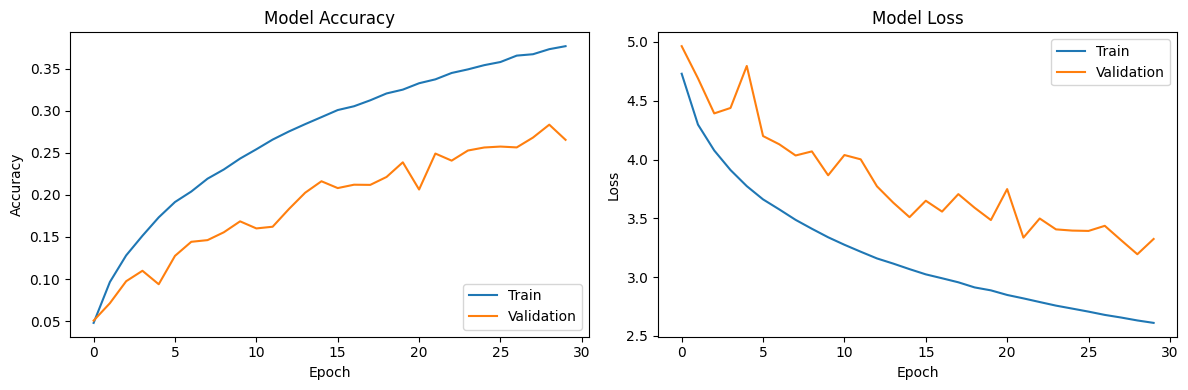

In [10]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()